# Lesson 29: PyTorch training loop activity - SOLUTION

This notebook contains the solution for adding batching and validation to the PyTorch training loop.

## Notebook set-up

### Imports

In [8]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [9]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 100
print_every = 10 # Print training progress every n epochs

## 1. Load preprocessed data

In [10]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')

training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

print(f'Training samples: {len(training_df)}')
print(f'Testing samples: {len(testing_df)}')
print(f'Features: {features}')
print(f'Label: {label}')

Training samples: 15480
Testing samples: 5160
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: MedHouseVal


## 2. Prepare PyTorch tensors and DataLoaders - SOLUTION

This section creates tensors, splits training data into train/validation sets, and creates DataLoaders for batching.

In [11]:
# Convert dataframes to PyTorch tensors and move to device
X_train_full = torch.tensor(training_df[features].values, dtype=torch.float32).to(device)
y_train_full = torch.tensor(training_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(testing_df[features].values, dtype=torch.float32).to(device)
y_test = torch.tensor(testing_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

In [12]:
# Split training data into train and validation sets (80/20)
n_samples = X_train_full.shape[0]
n_val = int(n_samples * 0.2)
n_train = n_samples - n_val

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

# Create train and validation tensors
X_train = X_train_full[train_indices]
y_train = y_train_full[train_indices]
X_val = X_train_full[val_indices]
y_val = y_train_full[val_indices]

In [13]:
# Create DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {n_train}')
print(f'Validation samples: {n_val}')
print(f'Batch size: {batch_size}')
print(f'Training batches per epoch: {len(train_loader)}')

Training samples: 12384
Validation samples: 3096
Batch size: 32
Training batches per epoch: 387


In [14]:
x0, y0 = train_loader.dataset[0]

print(type(y0))
print("Label value:", y0)
print("Label shape:", y0.shape if hasattr(y0, "shape") else "scalar")
print("Label dtype:", y0.dtype)

<class 'torch.Tensor'>
Label value: tensor([-0.8357], device='cuda:0')
Label shape: torch.Size([1])
Label dtype: torch.float32


## 3. Build model

In [15]:
model = nn.Sequential(
    nn.Linear(8, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1)
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Training function - SOLUTION

This solution accepts DataLoaders and iterates over batches, computing validation metrics after each epoch.

In [16]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 50,
    print_every: int = 5
) -> dict[str, list[float]]:
    '''Training loop with batching and validation.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training batches
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        epochs: Number of training epochs
        print_every: Print progress every N epochs
    
    Returns:
        Dictionary containing training history
    '''
    
    history = {
        'loss': [], 
        'val_loss': []
    }
    
    # Outer epoch loop
    for epoch in range(epochs):

        # Zero epoch losses & batch count
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        n_batches = 0

        # Set model to training mode
        model.train()
        
        # Inner batch loop
        for (X_train, y_train), (X_val, y_val) in zip(train_loader, val_loader):

            # Forward pass
            optimizer.zero_grad()
            train_predictions = model(X_train)
            train_loss = criterion(train_predictions, y_train)
            
            # Backward pass
            train_loss.backward()
            optimizer.step()
            
            # Sum training loss
            epoch_train_loss += train_loss.item()

            # Calculate validation loss
            val_predictions = model(X_val)
            val_loss = criterion(val_predictions, y_val)
            epoch_val_loss += val_loss.item()

            n_batches += 1
        
        # Average training loss for the epoch
        history['loss'].append(epoch_train_loss / n_batches)
        history['val_loss'].append(epoch_val_loss / n_batches)

        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - '
                  f'Train Loss: {history["loss"][-1]:.4f} - '
                  f'Val Loss: {history["val_loss"][-1]:.4f}')
    
    print('\nTraining complete.')

    return history

## 5. Train model

In [17]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=num_epochs,
    print_every=print_every
)

Epoch [10/100] - Train Loss: 0.3302 - Val Loss: 0.3381
Epoch [20/100] - Train Loss: 0.2863 - Val Loss: 0.3123
Epoch [30/100] - Train Loss: 0.2684 - Val Loss: 0.2992
Epoch [40/100] - Train Loss: 0.2566 - Val Loss: 0.2849
Epoch [50/100] - Train Loss: 0.2738 - Val Loss: 0.2764
Epoch [60/100] - Train Loss: 0.2478 - Val Loss: 0.2737
Epoch [70/100] - Train Loss: 0.2560 - Val Loss: 0.2665
Epoch [80/100] - Train Loss: 0.2463 - Val Loss: 0.2671
Epoch [90/100] - Train Loss: 0.2419 - Val Loss: 0.2647
Epoch [100/100] - Train Loss: 0.2483 - Val Loss: 0.2606

Training complete.


## 6. Learning curves

Now showing both training and validation loss.

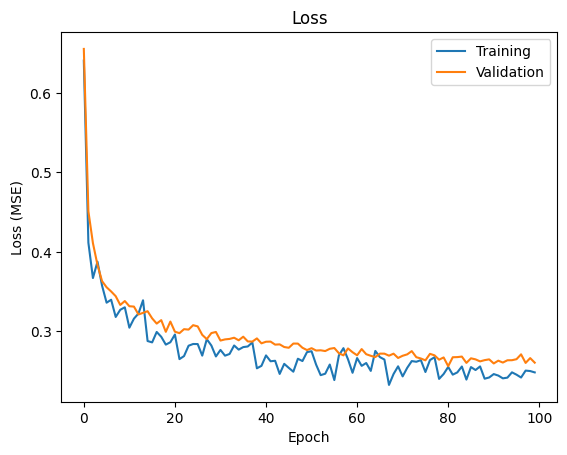

In [18]:
plt.title('Loss')
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## 7. Test set evaluation

In [19]:
# Set model to evaluation mode
model.eval()

# Make predictions (no gradient calculation needed)
with torch.no_grad():
    predictions = model(X_test).cpu().numpy().flatten()

# Calculate R²
ss_res = np.sum((testing_df[label].values - predictions) ** 2)
ss_tot = np.sum((testing_df[label].values - np.mean(testing_df[label].values)) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7673


## 8. Performance analysis

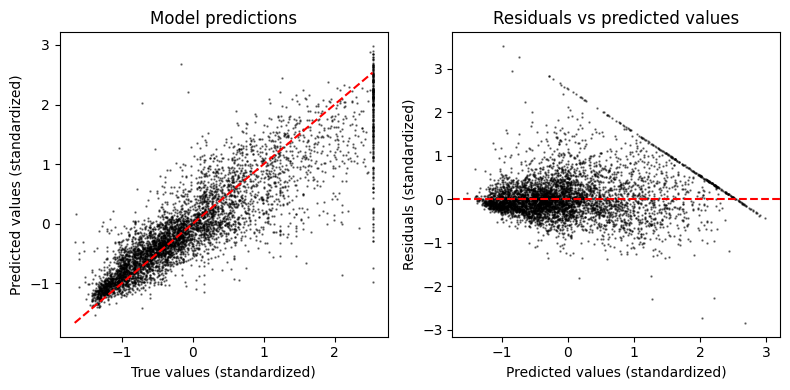

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Model predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()